In [2]:
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation
from tensorflow.keras.optimizers import SGD

In [3]:
class ODEsolver(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.mse = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
          return [self.loss_tracker]

    def train_step(self, data):
        batch_size = tf.shape(data)[0]
        min = tf.cast(tf.reduce_min(data),tf.float32)
        max = tf.cast(tf.reduce_max(data),tf.float32)
        x = tf.random.uniform((batch_size,1), minval=min, maxval=max)

        with tf.GradientTape() as tape:
            with tf.GradientTape() as tape2:
                tape2.watch(x)
                y_pred = self(x, training=True)
            dy = tape2.gradient(y_pred, x) #derivada del modelo con respecto a entradas x
            x_0 = tf.zeros((batch_size, 1)) #valor de x en condicion inicial x_0=0
            y_0 = self(x_0, training=True) #valor del modelo en en x_0
            eq = x*dy + y_pred - x**2*tf.math.cos(x)  #Ecuacion diferencial evaluada en el modelo. Queremos que sea muy pequeno
            ic = y_0 - 0. #valor que queremos para la condicion inicial o el modelo en x_0
            loss = self.mse(0., eq) + self.mse(0., ic)

        
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        
        self.loss_tracker.update_state(loss)
        
        return {"loss": self.loss_tracker.result()}

In [19]:
# model definition
model = ODEsolver()

model.add(Dense(10, activation = 'tanh', input_shape=(1,)))
model.add(Dense(10, activation='tanh'))
model.add(Dense(10, activation='tanh'))
model.add(Dense(1, activation='linear'))

model.summary()

Model: "od_esolver_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 10)                20        
                                                                 
 dense_13 (Dense)            (None, 10)                110       
                                                                 
 dense_14 (Dense)            (None, 10)                110       
                                                                 
 dense_15 (Dense)            (None, 1)                 11        
                                                                 
Total params: 251 (1004.00 Byte)
Trainable params: 251 (1004.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
x=tf.linspace(-5, 5, 200)

model.compile(optimizer='rmsprop', metrics=['loss'])
history = model.fit(x, epochs=300, verbose=0)
model.save("eq1.h5")

In [21]:
x_test = tf.linspace(-5, 5, 200)
prediction = model.predict(x_test)

7/7 [==============================] - 0s 1ms/step


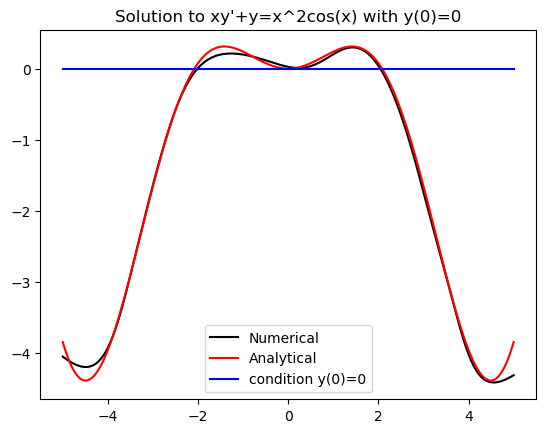

In [22]:
plt.title('Solution to xy\'+y=x^2cos(x) with y(0)=0')
plt.plot(x_test, prediction, color='black', label='Numerical')
plt.plot(x_test, x*np.sin(x)-(2/x)*(np.sin(x)-x*np.cos(x)), color='red',  label='Analytical')
plt.plot(x_test, 0*x, label='condition y(0)=0', color='blue')
plt.legend()
plt.show()

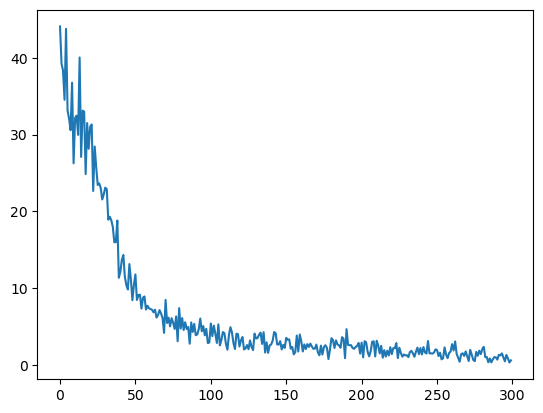

In [23]:
plt.plot(history.history['loss'])
plt.show()